# Notebook 04 — Time-Window Features & Boosting

## Step 1 — Title, imports, paths, config

In [12]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

from xgboost import XGBClassifier

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
sns.set(style="whitegrid")

RANDOM_SEED = 42

PATIENT_COL = "Patient_ID"
TIME_COL = "ICULOS"
TARGET_COL = "SepsisLabel"
LABEL_COL = "Label_6h"

WINDOW_SIZES = [3, 6, 12]  # history windows for feature engineering

def find_project_root() -> Path:
    cur = Path.cwd().resolve()
    for candidate in [cur, *cur.parents]:
        if (candidate / "notebooks").exists() and (candidate / "reports").exists():
            return candidate
    return cur


PROJECT_ROOT = find_project_root()
REPORTS_ROOT = PROJECT_ROOT / "reports"

RESULTS_LABELING = REPORTS_ROOT / "results" / "02_labeling_eda"
RESULTS_THIS = REPORTS_ROOT / "results" / "04_time_window_boosting"
FIGURES_THIS = REPORTS_ROOT / "figures" / "04_time_window_boosting"

RESULTS_THIS.mkdir(parents=True, exist_ok=True)
FIGURES_THIS.mkdir(parents=True, exist_ok=True)

EXPORTED_FIGURES: list[tuple[str, plt.Figure]] = []

print("cwd:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("Labeling results dir:", RESULTS_LABELING)
print("This notebook results dir:", RESULTS_THIS)
print("This notebook figures dir:", FIGURES_THIS)

cwd: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\notebooks
PROJECT_ROOT: C:\Users\marta\PyCharmMiscProject\sepsis-predictor
Labeling results dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda
This notebook results dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\04_time_window_boosting
This notebook figures dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\04_time_window_boosting


## Step 2 — Load labeled data (from Notebook 02)

In [13]:
train_path = RESULTS_LABELING / "02_labeling_eda_train.csv"
test_path = RESULTS_LABELING / "02_labeling_eda_test.csv"

print("Loading labeled datasets from:")
print("  train:", train_path)
print("  test :", test_path)

assert train_path.exists(), f"Missing file: {train_path}"
assert test_path.exists(), f"Missing file: {test_path}"

train_df = pd.read_csv(train_path, low_memory=False)
test_df = pd.read_csv(test_path, low_memory=False)

for name, df in [("train_df", train_df), ("test_df", test_df)]:
    assert df.columns.is_unique, f"Duplicate column names in {name}"

print("\nLoaded datasets:")
print("  train_df:", train_df.shape)
print("  test_df :", test_df.shape)
display(train_df.head())

Loading labeled datasets from:
  train: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_train.csv
  test : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_test.csv

Loaded datasets:
  train_df: (1220925, 19)
  test_df : (306301, 19)


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,sepsis_onset_time,Label_6h
0,-0.981406,0.738859,-0.890076,-1.095866,-1.132851,-0.464943,-0.139349,0.068645,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,1,0,1,NaN,0
1,-0.942007,0.738859,-0.890076,-1.095866,-1.132851,-0.464943,-0.139349,0.068645,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,2,0,1,NaN,0
2,-0.902609,0.269532,0.700883,-1.095866,-0.070135,0.216319,-0.139349,0.684351,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,3,0,1,NaN,0
3,-0.863210,0.328198,-0.890076,-1.095866,-0.070135,0.216319,-0.139349,2.326236,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,4,0,1,NaN,0
4,-0.823812,1.090853,-3.276514,-1.095866,-0.070135,0.556631,-0.139349,1.197440,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,5,0,1,NaN,0


## Step 3 — Schema checks and per-patient hour index

In [14]:
# Key columns must be present and Label_6h must be clean 0/1
for df_name, df in [("train_df", train_df), ("test_df", test_df)]:
    for col in [PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL, "sepsis_onset_time"]:
        assert col in df.columns, f"{col} missing in {df_name}"

    assert df[LABEL_COL].isin([0, 1]).all(), (
        f"{df_name}: {LABEL_COL} has values other than 0/1"
    )
    assert df[LABEL_COL].isna().sum() == 0, (
        f"{df_name}: {LABEL_COL} contains NaNs"
    )

# Sort and add increasing index per patient
for name, df in [("train_df", train_df), ("test_df", test_df)]:
    df.sort_values([PATIENT_COL, TIME_COL], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df["hour_index"] = df.groupby(PATIENT_COL).cumcount()
    print(f"{name}: rows={df.shape[0]}, patients={df[PATIENT_COL].nunique()}")

print("\nSchema checks passed and hour_index added.")


train_df: rows=1220925, patients=32268
test_df: rows=306301, patients=8068

Schema checks passed and hour_index added.


## Step 3 — Schema checks and per-patient hour index

In [15]:
EXCLUDE_BASE_COLS = {
    PATIENT_COL,
    TIME_COL,
    TARGET_COL,
    LABEL_COL,
    "sepsis_onset_time",
    "hour_index",
}

base_feature_cols = [
    c for c in train_df.columns
    if c not in EXCLUDE_BASE_COLS and pd.api.types.is_numeric_dtype(train_df[c])
]

print(f"Number of base numeric feature columns: {len(base_feature_cols)}")
print("Sample base features:", base_feature_cols[:10])
print("Configured history windows (hours):", WINDOW_SIZES)

Number of base numeric feature columns: 14
Sample base features: ['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Glucose', 'Age']
Configured history windows (hours): [3, 6, 12]


## Step 5 — Multi-window feature engineering (3h / 6h / 12h)

In [16]:
def build_multi_window_features(
    df: pd.DataFrame,
    feature_cols: list[str],
    window_sizes: list[int],
) -> pd.DataFrame:
    """
    For each numeric base feature and each window size, add:
    - rolling mean / min / max / std
    - simple slope over the window
    - fraction of missing values in the window
    All operations are done per patient and use only current + past values.
    """
    df_out = df.copy()

    new_features = {}

    for col in feature_cols:
        series = df_out[col]
        # group by patient for all rolling ops
        grouped_series = series.groupby(df_out[PATIENT_COL])

        for w in window_sizes:
            roll = grouped_series.rolling(w, min_periods=w)

            new_features[f"{col}_mean_{w}h"] = (
                roll.mean().reset_index(level=0, drop=True)
            )
            new_features[f"{col}_min_{w}h"] = (
                roll.min().reset_index(level=0, drop=True)
            )
            new_features[f"{col}_max_{w}h"] = (
                roll.max().reset_index(level=0, drop=True)
            )
            new_features[f"{col}_std_{w}h"] = (
                roll.std(ddof=0).reset_index(level=0, drop=True)
            )

            # slope: (current - value w-1 steps ago) / (w-1)
            first_in_window = grouped_series.shift(w - 1)
            new_features[f"{col}_slope_{w}h"] = (
                series - first_in_window
            ) / (w - 1)

            # missing fraction: rolling mean over isna()
            missing = series.isna()
            grouped_missing = missing.groupby(df_out[PATIENT_COL])
            miss_roll = grouped_missing.rolling(w, min_periods=w)
            new_features[f"{col}_missingfrac_{w}h"] = (
                miss_roll.mean().reset_index(level=0, drop=True)
            )

    # concatenate all new features at once to avoid fragmentation warnings
    new_df = pd.concat([df_out, pd.DataFrame(new_features)], axis=1)

    return new_df.copy()


print("Adding multi-window features to train/test...")
train_win = build_multi_window_features(train_df, base_feature_cols, WINDOW_SIZES)
test_win = build_multi_window_features(test_df, base_feature_cols, WINDOW_SIZES)

print("Shapes with multi-window features:")
print("  train_win:", train_win.shape)
print("  test_win :", test_win.shape)
display(train_win.iloc[:3, :15])

Adding multi-window features to train/test...
Shapes with multi-window features:
  train_win: (1220925, 272)
  test_win : (306301, 272)


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,-0.981406,0.738859,-0.890076,-1.095866,-1.132851,-0.464943,-0.139349,0.068645,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,1
1,-0.942007,0.738859,-0.890076,-1.095866,-1.132851,-0.464943,-0.139349,0.068645,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,2
2,-0.902609,0.269532,0.700883,-1.095866,-0.070135,0.216319,-0.139349,0.684351,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,3


## Step 6 — Build modeling cohort (rows with full multi-window history)

In [17]:
max_window = max(WINDOW_SIZES)
print(f"Largest history window: {max_window} hours")

def build_modeling_cohort(
    df_with_win: pd.DataFrame,
    max_window_size: int,
) -> pd.DataFrame:
    # require at least max_window_size hours since ICU admission
    mask = df_with_win["hour_index"] >= (max_window_size - 1)
    cohort = df_with_win.loc[mask].reset_index(drop=True)
    return cohort


train_model_df = build_modeling_cohort(train_win, max_window)
test_model_df = build_modeling_cohort(test_win, max_window)

print("Modeling cohorts (rows with full history across all windows):")
print("  train_model_df:", train_model_df.shape)
print("  test_model_df :", test_model_df.shape)

print("\nPatients retained after windowing:")
print("  train patients:", train_model_df[PATIENT_COL].nunique())
print("  test patients :", test_model_df[PATIENT_COL].nunique())

display(train_model_df[[PATIENT_COL, TIME_COL, LABEL_COL]].head())


Largest history window: 12 hours
Modeling cohorts (rows with full history across all windows):
  train_model_df: (872075, 272)
  test_model_df : (218991, 272)

Patients retained after windowing:
  train patients: 31099
  test patients : 7787


,Patient_ID,ICULOS,Label_6h
0,1,12,0
1,1,13,0
2,1,14,0
3,1,15,0
4,1,16,0


## Step 7 — Build feature matrix (X) and target vector (y)

In [18]:
FEATURE_EXCLUDE = {
    PATIENT_COL,
    TIME_COL,
    TARGET_COL,
    LABEL_COL,
    "sepsis_onset_time",
    "hour_index",
}

feature_cols = [
    c for c in train_model_df.columns
    if c not in FEATURE_EXCLUDE and pd.api.types.is_numeric_dtype(train_model_df[c])
]

print(f"Number of feature columns (multi-window): {len(feature_cols)}")
print("Sample features:", feature_cols[:12])

X_train_full = train_model_df[feature_cols].copy()
y_train_full = train_model_df[LABEL_COL].values

X_test = test_model_df[feature_cols].copy()
y_test = test_model_df[LABEL_COL].values

print("\nShapes of model matrices:")
print("  X_train_full:", X_train_full.shape)
print("  y_train_full:", y_train_full.shape)
print("  X_test      :", X_test.shape)
print("  y_test      :", y_test.shape)

Number of feature columns (multi-window): 266
Sample features: ['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Glucose', 'Age', 'Gender', 'Unit1']

Shapes of model matrices:
  X_train_full: (872075, 266)
  y_train_full: (872075,)
  X_test      : (218991, 266)
  y_test      : (218991,)


## Step 8 — Patient-level train/validation split

In [19]:
# Patient-level label: does this patient ever have Label_6h == 1?
patient_level_train = (
    train_model_df
    .groupby(PATIENT_COL)[LABEL_COL]
    .max()
    .reset_index()
    .rename(columns={LABEL_COL: "any_pos_6h"})
)

patient_ids = patient_level_train[PATIENT_COL].values
patient_labels = patient_level_train["any_pos_6h"].values

print("Total train patients (after windowing):", len(patient_ids))
print("Patients with any positive 6h label:", patient_labels.sum(),
      f"({patient_labels.mean():.3%})")

train_ids, val_ids = train_test_split(
    patient_ids,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=patient_labels,
)

print("\nSplit sizes (patients):")
print("  train_ids:", len(train_ids))
print("  val_ids  :", len(val_ids))

# Map back to row-level cohorts
train_mask_inner = train_model_df[PATIENT_COL].isin(train_ids)
val_mask = train_model_df[PATIENT_COL].isin(val_ids)

X_train = X_train_full.loc[train_mask_inner].reset_index(drop=True)
y_train = y_train_full[train_mask_inner]

X_val = X_train_full.loc[val_mask].reset_index(drop=True)
y_val = y_train_full[val_mask]

print("\nRow-level shapes after patient-level split:")
print("  X_train:", X_train.shape, "  y_train:", y_train.shape)
print("  X_val  :", X_val.shape,   "  y_val  :", y_val.shape)

def print_label_stats(name: str, y: np.ndarray):
    unique, counts = np.unique(y, return_counts=True)
    freq = dict(zip(unique, counts))
    total = len(y)
    print(f"{name}: n={total}, positives={freq.get(1, 0)} "
          f"({freq.get(1, 0) / total:.3%})")

print("\nLabel_6h prevalence by split:")
print_label_stats("TRAIN", y_train)
print_label_stats("VAL  ", y_val)
print_label_stats("TEST ", y_test)

Total train patients (after windowing): 31099
Patients with any positive 6h label: 1572 (5.055%)

Split sizes (patients):
  train_ids: 24879
  val_ids  : 6220

Row-level shapes after patient-level split:
  X_train: (699165, 266)   y_train: (699165,)
  X_val  : (172910, 266)   y_val  : (172910,)

Label_6h prevalence by split:
TRAIN: n=699165, positives=7137 (1.021%)
VAL  : n=172910, positives=1791 (1.036%)
TEST : n=218991, positives=2120 (0.968%)


## Step 9 — XGBoost tuning on validation set (small grid)

In [20]:
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
pos_weight = n_neg / n_pos
print(f"XGBoost scale_pos_weight (neg/pos) ≈ {pos_weight:.1f}")

param_grid = [
    {"n_estimators": 300, "max_depth": 4, "learning_rate": 0.05,
     "subsample": 0.8, "colsample_bytree": 0.8},
    {"n_estimators": 400, "max_depth": 4, "learning_rate": 0.05,
     "subsample": 0.9, "colsample_bytree": 0.9},
    {"n_estimators": 400, "max_depth": 5, "learning_rate": 0.05,
     "subsample": 0.8, "colsample_bytree": 0.8},
    {"n_estimators": 500, "max_depth": 4, "learning_rate": 0.03,
     "subsample": 0.8, "colsample_bytree": 0.8},
]

tuning_rows = []

for i, params in enumerate(param_grid, start=1):
    print(f"\nConfig {i}/{len(param_grid)}: {params}")

    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=pos_weight,
        tree_method="hist",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        **params,
    )

    xgb.fit(X_train, y_train)

    val_probs = xgb.predict_proba(X_val)[:, 1]
    auroc = metrics.roc_auc_score(y_val, val_probs)
    auprc = metrics.average_precision_score(y_val, val_probs)

    print(f"  VAL AUROC = {auroc:.4f}, AUPRC = {auprc:.4f}")

    row = {
        "config_id": i,
        "n_estimators": params["n_estimators"],
        "max_depth": params["max_depth"],
        "learning_rate": params["learning_rate"],
        "subsample": params["subsample"],
        "colsample_bytree": params["colsample_bytree"],
        "val_auroc": auroc,
        "val_auprc": auprc,
    }
    tuning_rows.append(row)

xgb_tuning_df = pd.DataFrame(tuning_rows)
display(xgb_tuning_df.sort_values("val_auprc", ascending=False))

tuning_path = RESULTS_THIS / "04_xgb_tuning_results.csv"
xgb_tuning_df.to_csv(tuning_path, index=False)
print("Saved XGBoost tuning results to:", tuning_path)

# Pick best configuration by validation AUPRC
best_row = xgb_tuning_df.sort_values("val_auprc", ascending=False).iloc[0]
print("\nBest config by VAL AUPRC:")
print(best_row.to_dict())

XGBoost scale_pos_weight (neg/pos) ≈ 97.0

Config 1/4: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8}
  VAL AUROC = 0.8077, AUPRC = 0.0566

Config 2/4: {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9}
  VAL AUROC = 0.7985, AUPRC = 0.0559

Config 3/4: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8}
  VAL AUROC = 0.7893, AUPRC = 0.0550

Config 4/4: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.8}
  VAL AUROC = 0.8054, AUPRC = 0.0562


,config_id,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,val_auroc,val_auprc
0,1,300,4,0.05,0.8,0.8,0.807708,0.056622
3,4,500,4,0.03,0.8,0.8,0.805371,0.056203
1,2,400,4,0.05,0.9,0.9,0.798509,0.055940
2,3,400,5,0.05,0.8,0.8,0.789250,0.055015


Saved XGBoost tuning results to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\04_time_window_boosting\04_xgb_tuning_results.csv

Best config by VAL AUPRC:
{'config_id': 1.0, 'n_estimators': 300.0, 'max_depth': 4.0, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'val_auroc': 0.8077080251690674, 'val_auprc': 0.056621962219436064}


## Step 10 — Final XGBoost model (train+val) and test evaluation

Training final XGBoost with params: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8}
Final XGBoost trained.

[TEST — Final XGBoost]
AUROC: 0.8238
AUPRC: 0.0552
F1   : 0.0776
ACC  : 0.8583


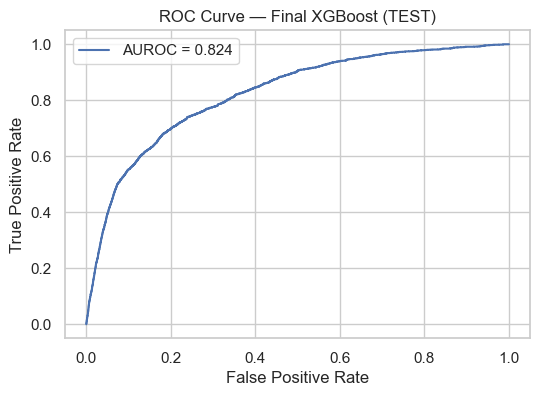

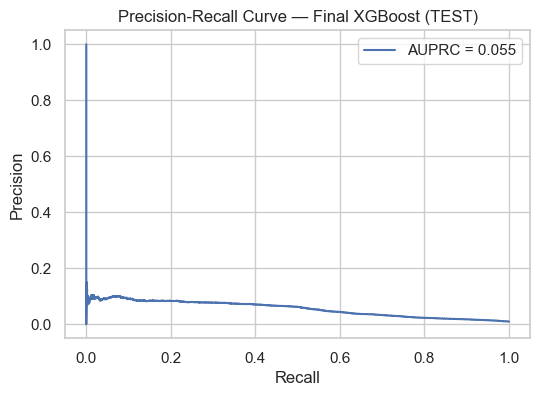

In [21]:
best_params = {
    "n_estimators": int(best_row["n_estimators"]),
    "max_depth": int(best_row["max_depth"]),
    "learning_rate": float(best_row["learning_rate"]),
    "subsample": float(best_row["subsample"]),
    "colsample_bytree": float(best_row["colsample_bytree"]),
}

print("Training final XGBoost with params:", best_params)

X_train_final = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_train_final = np.concatenate([y_train, y_val])

final_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=pos_weight,
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=-1,
    **best_params,
)

final_xgb.fit(X_train_final, y_train_final)
print("Final XGBoost trained.")

# --- Evaluate on TEST ---
test_probs = final_xgb.predict_proba(X_test)[:, 1]
test_preds = (test_probs >= 0.5).astype(int)

test_auroc = metrics.roc_auc_score(y_test, test_probs)
test_auprc = metrics.average_precision_score(y_test, test_probs)
test_f1 = metrics.f1_score(y_test, test_preds)
test_acc = metrics.accuracy_score(y_test, test_preds)

print("\n[TEST — Final XGBoost]")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")
print(f"F1   : {test_f1:.4f}")
print(f"ACC  : {test_acc:.4f}")

# ROC / PR curves on TEST
fig, ax = plt.subplots(figsize=(6, 4))
fpr, tpr, _ = metrics.roc_curve(y_test, test_probs)
ax.plot(fpr, tpr, label=f"AUROC = {test_auroc:.3f}")
ax.set_title("ROC Curve — Final XGBoost (TEST)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
EXPORTED_FIGURES.append(("04_xgb_final_roc_test", fig))
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = metrics.precision_recall_curve(y_test, test_probs)
ax.plot(recall, precision, label=f"AUPRC = {test_auprc:.3f}")
ax.set_title("Precision-Recall Curve — Final XGBoost (TEST)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
EXPORTED_FIGURES.append(("04_xgb_final_pr_test", fig))
plt.show()

Incorporating temporal features across 3h–12h windows substantially improves the model’s ability to detect impending sepsis. The time-aware XGBoost achieved AUROC = 0.8238 and AUPRC = 0.0552 on the held-out test cohort, outperforming all static-feature baselines. The multi-window representation captures clinically meaningful physiological deterioration trajectories, which appears essential for early sepsis prediction.

## Step 11 — Export per-hour risk trajectories for train/val/test

In [22]:
# Probabilities for all TRAIN+VAL rows (same order as train_model_df)
all_train_probs = final_xgb.predict_proba(X_train_full)[:, 1]

train_traj_df = train_model_df[[PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL]].copy()
train_traj_df["risk_xgb_tw"] = all_train_probs

# mark which rows belonged to original train vs val split
split_flag = np.where(train_mask_inner, "train", "val")
train_traj_df["split_04"] = split_flag

test_traj_df = test_model_df[[PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL]].copy()
test_traj_df["risk_xgb_tw"] = final_xgb.predict_proba(X_test)[:, 1]
test_traj_df["split_04"] = "test"

train_traj_path = RESULTS_THIS / "04_xgb_risk_trajectories_trainval.csv"
test_traj_path = RESULTS_THIS / "04_xgb_risk_trajectories_test.csv"

train_traj_df.to_csv(train_traj_path, index=False)
test_traj_df.to_csv(test_traj_path, index=False)

print("Saved risk trajectories to:")
print("  train/val:", train_traj_path)
print("  test     :", test_traj_path)


Saved risk trajectories to:
  train/val: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\04_time_window_boosting\04_xgb_risk_trajectories_trainval.csv
  test     : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\04_time_window_boosting\04_xgb_risk_trajectories_test.csv


## Step 12 — Save tuning summary and export figures

In [23]:
metrics_summary = pd.DataFrame([
    {
        "model": "xgboost_timewindow",
        "test_auroc": test_auroc,
        "test_auprc": test_auprc,
        "test_f1": test_f1,
        "test_acc": test_acc,
    }
])

metrics_path = RESULTS_THIS / "04_boosting_model_metrics.csv"
metrics_summary.to_csv(metrics_path, index=False)
print("Saved final model metrics to:", metrics_path)

# Export all figures
for name, fig in EXPORTED_FIGURES:
    out_path = FIGURES_THIS / f"{name}.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print("Saved figure:", out_path)

print("\nAll figures successfully exported.")

Saved final model metrics to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\04_time_window_boosting\04_boosting_model_metrics.csv
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\04_time_window_boosting\04_xgb_final_roc_test.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\04_time_window_boosting\04_xgb_final_pr_test.png

All figures successfully exported.
